In [1]:
from doe_modules.simulation import MLR
from doe_modules.design import CLOO

In [2]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from doe_modules.simulation import AbstractSimulator
from doe_modules.design import DOE
from doe_modules.preferences import textcolor
# from doe_modules.preferences.cmap import test4

In [3]:
from doe_modules.preferences import outputdir

In [4]:
from typing import List
from doe_modules.preferences import textcolor

In [5]:
mapklike = [plt.cm.gist_rainbow_r((i + 2)/13) for i in range(11)]

edge_mapklike = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
    0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
    0, 1, 1, 0, 0, 0, 0, 0, 0,
    1, 1, 0, 0, 0, 0, 0, 0,
    0, 1, 0, 0, 0, 0, 0,
    0, 1, 0, 0, 0, 0,
    0, 1, 0, 0, 0,
    0, 1, 0, 0,
    1, 0, 0,
    1, 0,
    1
]

name_mapklike = {
    1: "EGFR", 2: "ERBB2", 3: "MET",
    4: "GRB2", 5: "PLC",
    6: "SOS", 7: "PKC",
    8: "RAS", 9: "RAF", 10: "MEK", 11: "ERK"
}

In [6]:
class MAPKLike(AbstractSimulator):
    def __init__(
        self, 
        random_state: int = 0,
        kwarg_v: dict = dict(mean=1, sigma=.8),
        kwarg_a: dict = dict(mean=2, sigma=.3),
        kwarg_b: dict = dict(mean=1, sigma=.5)
    ):
        super().__init__(
            n_factor=11, random_state=random_state, cmap=mapklike, 
            name="MAPK-like"
        )
        edge_assignsment = edge_mapklike
        seeds = np.random.randint(0, 2**32, 3)
        np.random.seed(seeds[0])
        self.v = {
            i+1: vi for i, vi in enumerate(
                np.random.lognormal(**kwarg_v, size=self.n_factor)
            )
        }
        np.random.seed(seeds[1])
        self.a = {
            i: sign * a for i, a, sign in zip(
                np.arange(1, self.n_factor + 1).astype(int),
                np.random.lognormal(**kwarg_a, size=self.n_factor),
                edge_assignsment[:self.n_factor]
            )
        }
        np.random.seed(seeds[2])
        self.b = {
            i: sign * b for i, b, sign in zip(
                [
                    102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
                    203, 204, 205, 206, 207, 208, 209, 210, 211,
                    304, 305, 306, 307, 308, 309, 310, 311,
                    405, 406, 407, 408, 409, 410, 411,
                    506, 507, 508, 509, 510, 511,
                    607, 608, 609, 610, 611,
                    708, 709, 710, 711,
                    809, 810, 811,
                    910, 911,
                    1011
                ],
                np.random.lognormal(**kwarg_b, size=55),
                edge_assignsment[self.n_factor:]
            )
        }

    def run(
        self, 
        design_array, 
        random_state: int = 0,
        kwarg_err: dict = dict(loc=0, scale=1),
    ):
        super().run(design_array=design_array, random_state=random_state)
        e = np.random.normal(**kwarg_err, size=self.n_factor + 1)
        f = lambda x: max(0, x)
        c = self.c
        
        upstreams = {}
        xs = {}
        idx_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        
        for i in idx_list:
            upstream_list = [ii for ii in idx_list if ii < i]
            upstream = 0 if len(upstream_list) == 0 else np.sum([self.b[100 * ii + i] * xs[ii] for ii in xs])
            xs = {**xs, i: f(c[i] * (self.v[i] + e[i] + upstream))}
            # print(xs)
        self.c = c
        self.x = xs
        self.y = f(sum([self.a[i + 1] * self.x[i + 1] for i in range(self.n_factor)]) + e[0])
        return self.y
    

    def plot(
        self,
        ax: plt.Axes,
        names: dict = None
    ):

        dat = pd.DataFrame(dict(
            x=[1, 4.5, 8, 3, 6, 3, 6, 3, 6, 9, 12], 
            y=[10, 10, 10, 7, 7, 4, 4, 1, 1, 1, 1]
        ))
        
        for i, (x, y) in enumerate(zip(dat.x, dat.y)):
            ax.fill_between([x - 1, x + 1], [y - .5] * 2, [y + .5] * 2, color=mapklike[i])


        box_top = -2
        box_bottom = -3

        ax.fill_between([1.5, 12.5], [box_bottom] * 2, [box_top] * 2, color=".7", alpha=.2)
        ax.text(7, (box_top + box_bottom) / 2, "output value"if names is None else "phenotype", ha="center", va="center")

        for i in range(self.n_factor):
            x, y = dat.x[i], dat.y[i]
            alpha = np.linspace(0.5, 1, self.n_factor)[i]
            ax.text(
                x, y, 
                "$x_{" + f"{(i + 1)}" + "}$" if names is None else names[i + 1], 
                va="center", ha="center", c=textcolor(mapklike[i]))
            
            if self.a[i + 1] != 0:
                ax.vlines(x, box_top, y, color=mapklike[i], zorder=-100, alpha=alpha)
                ax.scatter(
                    x, box_top + .25 if self.a[i + 1] > 0 else box_top, 
                    color=mapklike[i], marker="v" if self.a[i + 1] > 0 else "$-$"
                )
                # ax.text(x, box_top + 1, "$a_{" + f"{(i + 1)}" + "}$" if names is None else "", va="center", ha="left")
                
        ap = lambda c: dict(
            shrink=0, width=1, headwidth=5, 
            headlength=5, connectionstyle="arc3",
            facecolor=c, edgecolor=c
        )
        
        ax.annotate("", [3, 7.5], [1, 9.5], arrowprops=ap(mapklike[0]))
        ax.annotate("", [6, 7.5], [1, 9.5], arrowprops=ap(mapklike[0]))
        ax.annotate("", [3, 7.5], [4.5, 9.5], arrowprops=ap(mapklike[1]))
        ax.annotate("", [6, 7.5], [4.5, 9.5], arrowprops=ap(mapklike[1]))
        ax.annotate("", [3, 7.5], [8, 9.5], arrowprops=ap(mapklike[2]))
        ax.annotate("", [6, 7.5], [8, 9.5], arrowprops=ap(mapklike[2]))
        ax.annotate("", [3, 4.5], [3, 6.5], arrowprops=ap(mapklike[3]))
        ax.annotate("", [6, 4.5], [6, 6.5], arrowprops=ap(mapklike[4]))
        ax.annotate("", [3, 1.5], [3, 3.5], arrowprops=ap(mapklike[5]))
        ax.annotate("", [6, 1.5], [6, 3.5], arrowprops=ap(mapklike[6]))
        ax.annotate("", [5, 1], [4, 1], arrowprops=ap(mapklike[7]))
        ax.annotate("", [8, 1], [7, 1], arrowprops=ap(mapklike[8]))
        ax.annotate("", [11, 1], [10, 1], arrowprops=ap(mapklike[9]))

        ax.set_xlim(0, 14)
        ax.set_ylim(-3.0, 11)
        ax.axis("off");
        
#  
#         return None


    def simulate(
        self,
        design: DOE = None,
        n_rep: int = 1,
        random_state: int = 0,
        plot: bool = False,
        ax: np.ndarray = None,
        titles: List[str] = None,
        model_kwargs: dict = {},
        **kwargs
    ):
        super().simulate(
            design=design, n_rep=n_rep,
            random_state=random_state,
            plot=plot, ax=ax, 
            titles=titles,
            model_kwargs=model_kwargs,
            **kwargs
        )


    def scatterview(
        self,
        ax: plt.Axes
    ):
        super().scatterview(ax=ax)

Text(0.5, 1.0, 'MAPK signaling cascade\n(Kim M and Kim E, $BMC\\;Bioinformatics$ (2022))')

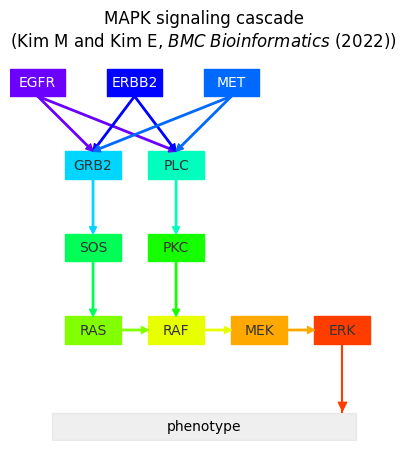

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

model = MAPKLike()

model.plot(ax=ax, names=name_mapklike)

ax.set_title("MAPK signaling cascade\n(Kim M and Kim E, $BMC\;Bioinformatics$ (2022))")

# if conf.savefig:
#     fig.savefig(f"{outputdir}/esm9", **kwarg_savefig)

In [8]:
from doe_modules.simulation.esm_metrics import *

In [10]:
pbsi(np.array(edge_mapklike))

0.34393939393939393

Text(0.5, 1.0, 'MAPK-like')

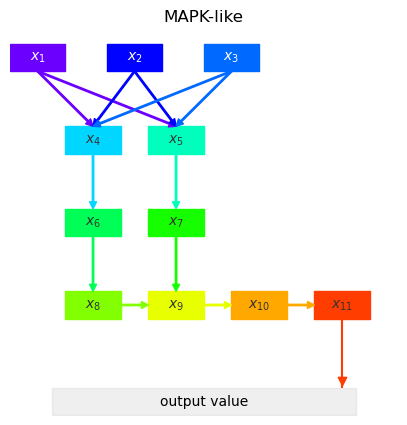

In [145]:
fig, ax = plt.subplots(figsize=(5, 5))

model = MAPKLike()

model.plot(ax=ax)

ax.set_title("MAPK-like")

# if conf.savefig:
#     fig.savefig(f"{outputdir}/esm9", **kwarg_savefig)

In [153]:
kwarg_err = dict(loc=0, scale=2)

mapk_ff, mapk_pb, mapk_cloo = [MAPKLike()] * 3
mapk_ff.simulate(design=FullFactorial, n_rep=3)
mapk_pb.simulate(design=PlackettBurman, n_rep=3)
mapk_cloo.simulate(design=CLOO, n_rep=3)

In [154]:
mapk_gt = MLR(mapk_ff).summary(anova=True, dtype=int, fill_nan=True)

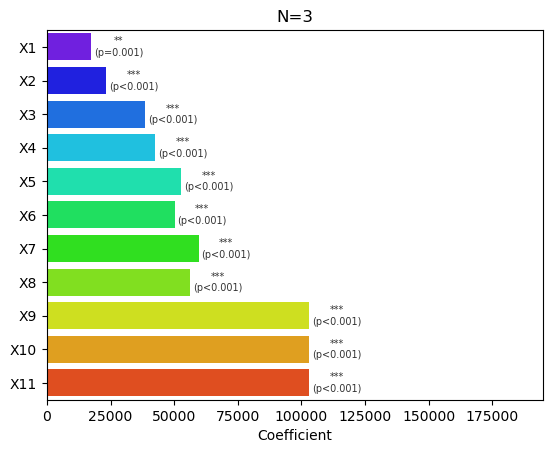

In [155]:
MLR(mapk_ff).plot()

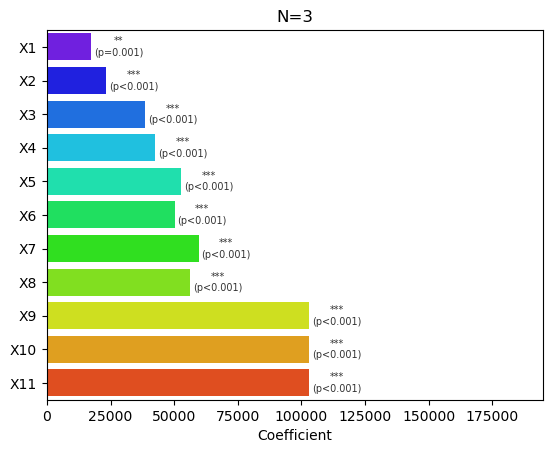

In [156]:
MLR(mapk_pb).plot()

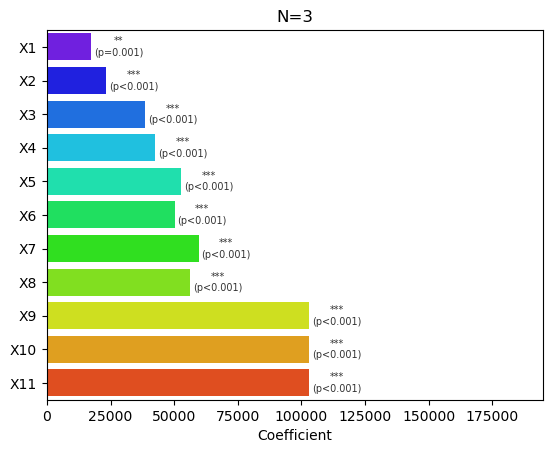

In [157]:
MLR(mapk_cloo).plot()